Created 6/21/2023

The purpose of this notebook is to push towards getting the final assembly of the simulated fields working. It will only call from the .py file versions of functions and classes, and will attempt to demonstrate full functionality from the beginning to the end of created a simulated data product.

I'm also going to treat this kind of like building up a tutorial notebook, because I think that will be useful later.

In [5]:
# imports
# %matplotlib widget
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import astropy.wcs as wcs
# import pandas as pd
# import copy
import random
import imp

# import butterpy as bp
import trc_funcs as trc
import field
import generator_classes as gen
# import PRF

# from astropy import units as u
# from astropy.coordinates import SkyCoord
# from astroquery.mast import Tesscut
# from astropy.stats import sigma_clip
from scipy import stats
# import scipy.signal
# import astropy.table

plt.rcParams.update({'figure.facecolor': 'white', 'axes.facecolor': 'white', 'savefig.facecolor': 'white'})


In [2]:
import tinygp

In [13]:
import imp
imp.reload(trc)
imp.reload(field)
imp.reload(gen)

<module 'generator_classes' from '/Users/raeholcomb/Documents/GitHub/sset/sset/generator_classes.py'>

## Set up your Generator Functions

Let's set up some code to inject variability into our background stars. To do this, we will use two types of objects: timeseries generators (which subclass from `TSGenerator`) and a function selector (`FunctionSelector`). TS generators store the code needed to caluate flux variability with different functional forms. The function selector is alike a library of TS generators, where each generator is given a probabilistic weight. When called, the function selector will use these weights to choose a generator, which will then generate a time series that can be injected into a stellar source.

Later: add more about the inputs to FS and TSG, and how to subclass a TSG.
TSG signals should be normalized to 1.

For the TSG, the only functions that need to be overwritten are:
- `__init__`: Provide default values for any necessary parameters.
- `__repr__`: Provide a name for the class
- `functional_form`: This function takes in a time array and a dictionary of parameter values, and outputs the flux and the dictionary of parameter values.

**Notes for next time:**
- Need to pass along name information when FS.generate_signal is called
- Need to implement a way to store the params in Field
- Consider: should functional_form out put the parameter values? It isn't necessary, but is it good to keep the output consistent with `generate_signal`?

**Notes for other stuff next time:**
- Need to add offset function for each source

TO DO: 
- define a table that will track all the values used to make this field
- source, position, variability function, params, offset
- ideally, you should be able to feed this table into a Field object and recreate the same field
- hm.... will have to think about implementation
- Maybe: add a function to the field class that can read in that table and populate the sources accordingly

In [14]:
imp.reload(gen)

<module 'generator_classes' from '/Users/raeholcomb/Documents/GitHub/sset/sset/generator_classes.py'>

In [15]:
# Set up the sine function generator
sine1 = gen.SineTSGenerator('sine1', 
                            params={'A':stats.uniform(loc=-.05, scale=.1), 
                                    'B':stats.uniform(loc=1, scale=5),
                                    'C':stats.uniform(loc=0, scale=2*np.pi), 
                                    'D':1})
time = np.array(np.linspace(0,1,10))

# print(sine1.sample())
time1 = np.linspace(0,10,1000)
sin_flux, sin_params = sine1.generate_signal(time1)

# print(sin_params)
# plt.plot(time1, sin_flux)
# plt.show()

In [16]:
# Set up the eclipsing binary generator
eb1 = gen.EclipsingBinaryTSGenerator('eb1', params={'radius_1':.15})
print(eb1.sample())
print(eb1.generate_signal(time))

{'radius_1': 0.15, 'radius_2': 0.05750795071864545, 'incl': 82.7825932719558, 'ecc': 0.03954190396068996, 'om': 3.141592653589793, 'period': 12.238447354588992, 'sbratio': 1.5732629902109616, 't_zero': 0.5744821311479896}
(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), {'radius_1': 0.15, 'radius_2': 0.16851052939685923, 'incl': 80.890201560751, 'period': 11.867517710433633, 'sbratio': 1.8646098227294832, 't_zero': 10.21466896551062, 'f_c': -0.4383222436588384, 'f_s': 0.0})


In [17]:
imp.reload(gen)

<module 'generator_classes' from '/Users/raeholcomb/Documents/GitHub/sset/sset/generator_classes.py'>

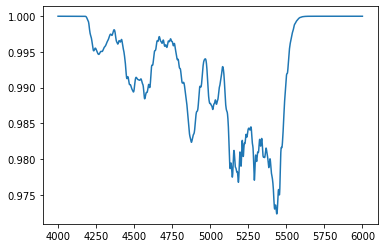

In [18]:
# set up the butterpy generator
time1 = np.arange(4000, 6000, .5)
bp1 = gen.ButterpyTSGenerator('bp1')
# print(bp1.sample())
# print(bp1.generate_signal(time1))
flux1, dict1 = bp1.generate_signal(time1)

plt.plot(time1, flux1)
plt.show()

In [19]:
dict1
# bp1.sample()

{'butterfly': True,
 'activity_rate': 1.0881046976955013,
 'cycle_length': 18.207148460469593,
 'cycle_overlap_lowerbound': 0.1,
 'decay_time': 1,
 'min_ave_lat': 35.46987519690497,
 'max_ave_lat_upperbound': 80,
 'alpha_med': 0.0009,
 'period': 6.800833695179555,
 'incl': 0.37141755327458514,
 'decay_timescale': 7.518183016579558,
 'diffrot_shear': 1,
 'tsim': 1825,
 'tstart': 0,
 'max_ave_lat': 76.09934183780746,
 'cycle_overlap': 0.28649687617395175}

In [20]:
# set up the function selector
fs = gen.FunctionSelector([(sine1,10), (eb1,10), (bp1,10)])
# fs.add_generator(sine1, 10)

# fs.select_generator()
time = np.array(np.linspace(0,1,10))
# gen.SineTSGenerator().generate_signal(time)
fs.instantiate_function(time)
# fs.select_generator()
# print(fs)

# fs.select_generator()

# time = np.linspace(1,10,200)
# flux, params = fs.instantiate_function(time)
# plt.plot(time,flux)
# plt.show()


('eb1',
 array([0.92715232, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.78651659]),
 {'radius_1': 0.15,
  'radius_2': 0.15053262484439062,
  'incl': 87.41304056439101,
  'period': 2.134375576405486,
  'sbratio': 1.8766503315657985,
  't_zero': 1.0274423890340727,
  'f_c': -0.17196457324815312,
  'f_s': 1.862645149230957e-09})

## tinygp dev

In [218]:
import jax
jax.config.update("jax_enable_x64", True)


In [219]:
def plot_kernel(kernel, **kwargs):
    dx = np.linspace(0, 5, 100)
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    plt.xlabel("dx")
    plt.ylabel("k(dx)")




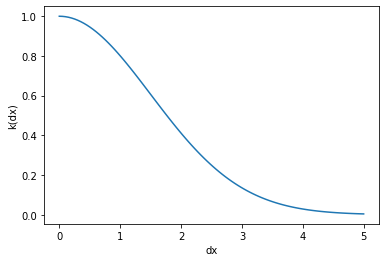

In [220]:
from tinygp import GaussianProcess
from tinygp import kernels

# define kernel
kernel = kernels.ExpSquared(scale=1.5)
plot_kernel(kernel)

# Let's make up some input coordinates (sorted for plotting purposes)
X = np.sort(np.random.default_rng(1).uniform(0, 10, 100))

gp = GaussianProcess(kernel, X)


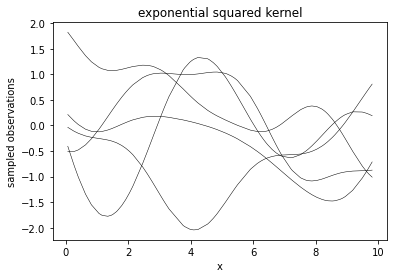

In [221]:
y = gp.sample(jax.random.PRNGKey(8), shape=(5,))
plt.plot(X, y.T, color="k", lw=0.5)
plt.xlabel("x")
plt.ylabel("sampled observations")
_ = plt.title("exponential squared kernel")

## Download Data

Let's begin by downloading some data. Every simulated TPF is based on a real TESS field, which allows us to build up the simulated images with realistic source positions, fluxes, and background features. Here we use the Lightkurve package to download:
- An FFI cutout, of the size we want the final simulated image to be. This image will provide us with information on the background, the positional data (neede for calculating differential velocity aberrations), and header information.
-  A pipeline target pixel file, centered on the same target as the FFI cutout. This is not strictly necessary, but it will provide us with aperture information which we can use when extracting a light curve from our simulated image.
- A catalog of sources within our FFI cutout.

In [40]:
lk.search_targetpixelfile(name, exptime=1800)

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 03,2018,TESS-SPOC,1800,396696273,0.0
1,TESS Sector 04,2018,TESS-SPOC,1800,396696273,0.0
2,TESS Sector 05,2018,TESS-SPOC,1800,396696273,0.0


In [21]:
# download data: tpf_pl, tpf_cutout, and source_cat
# pick a star/field to work with
tic = 396696273
name = "TIC " + str(tic)

# postage stamp tpf from pipeline
tpf_pl = lk.search_targetpixelfile(name, sector=3, exptime=1800).download(quality_bitmask="hard")

# grab the TESS FFI cut out
cutout_size=20
tpf_cutout = trc.get_cutout(name, cutout_size=cutout_size, sector=3)

# grab the catalog of sources
source_cat = trc.get_catalog(name, cutout_size=cutout_size, sector=3)


/opt/anaconda3/lib/python3.8/site-packages/lightkurve/search.py:407: LightkurveWarning: Warning: 7 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


In [4]:
tpf_cutout.animate()

In [42]:
# for multisector testing, also download sector 4
# download data: tpf_pl, tpf_cutout, and source_cat
# pick a star/field to work with
tic = 396696273
name = "TIC " + str(tic)

# copy to variable with consistent name
tpf_pl1 = tpf_pl
tpf_cutout1 = tpf_cutout
source_cat1 = source_cat

# postage stamp tpf from pipeline
tpf_pl2 = lk.search_targetpixelfile(name, sector=4, exptime=1800).download(quality_bitmask="hard")

# grab the TESS FFI cut out
cutout_size=20
tpf_cutout2 = trc.get_cutout(name, cutout_size=cutout_size, sector=4)


TypeError: get_catalog() got an unexpected keyword argument 'sector'

## Assemble Field

To assemble a Field object. Initialize with the following:
- stuff
Then you need to call:
- self.calc_bkg(polyorder=3)
- add_sources()
    - idx=0 will be the star at the center of your TPF. We recommend doing random_signal=False and signal_func=(your desired TSGenerator) for this star.
    - Then you can use random_signal=True to use the FunctionSelector to randomly populate your background stars

In [42]:
imp.reload(trc)
imp.reload(field)
imp.reload(gen)

<module 'generator_classes' from '/Users/raeholcomb/Documents/GitHub/sset/sset/generator_classes.py'>

In [181]:
# test Field class
# def signal_test(time):
#     """Placeholder for a signal added to a star"""
#     return 1 + 0.1 * np.sin(time * np.random.uniform(.5, 1.5))

# test = signal_test(tpf_cutout.time.value)
# plt.plot(tpf_cutout.time.value, test)
# plt.show()

# type(source_cat)

field1 = field.Field(tpf_cutout, source_cat , bkg_polyorder=2,
                     bkg_variability_generator=fs, 
                     pos_time=tpf_pl.time.value, 
                     pos_corr1=tpf_pl.pos_corr1, 
                     pos_corr2=tpf_pl.pos_corr2, 
                     noise_func=trc.exponential, 
                     noise_coeffs=np.array([ 0.00309107,  2.238249  , -0.0438357 ]),
                     add_offset=True)

# field1.calc_bkg(polyorder=2)

In [182]:
field1.add_signal(0, random_signal=True)
field1.add_signal(np.arange(1,len(field1.source_catalog)), random_signal=True)




In [183]:
field1.calc_empirical_noise()
field1.assemble()
field1.to_tpf()#.animate(clim=[120,260])

TessTargetPixelFile(TICID: None)

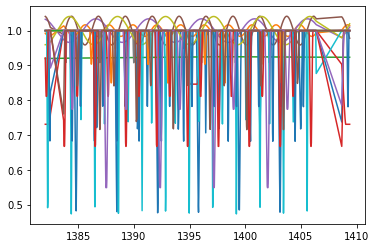

In [184]:
# plot all the signals added to the lc to see the range of what you have
for ind in range(len(field1.signals1D)):
    plt.plot(field1.orig_tpf.time.value, field1.signals1D[ind])
plt.show()

In [4]:
# assemble field
# probably need to add in stand ins for the empirical noise model and the LC pipeline

# later add in something to pick the field

In [102]:
imp.reload(trc)
imp.reload(field)
imp.reload(gen)

<module 'generator_classes' from '/Users/raeholcomb/Documents/GitHub/tess_sim/tess_sim/generator_classes.py'>

In [68]:
np.random.normal(loc=1., scale=.0125, size=None)
field1.source_catalog['offset'] = field1.generate_offset(size=len(field1.source_catalog))

In [ ]:
# mess around with the source_cat
sc = source_cat.copy()['ID', 'ra', 'dec', 'pmRA', 'pmDEC', 'Tmag', 'GAIA', 'contratio', 'dstArcSec']
sc[:3]

ID,ra,dec,pmRA,pmDEC,Tmag,GAIA,contratio,dstArcSec
str9,float64,float64,float64,float64,float64,str19,float64,float64
396696273,65.3022779524928,-55.1440218215514,-4.68889,-172.823,13.8321,4778975067622266240,0.04365064,0.0
396696276,65.2967867766935,-55.1550175340301,6.26182,11.5862,13.1813,4778974689665144576,nan,41.16484036924621
396696267,65.2754685020188,-55.124256141076,18.7408,15.5449,14.7411,4778975136341741568,nan,90.04050066606608


In [ ]:
# add columns for the Tflux, pixel positions, variability function, params, and offset

# flux
sc['Tflux'] = trc.mag_to_flux(sc['Tmag'])

# pix1, pix2 = self.orig_tpf.wcs.all_world2pix(self.source_cat['ra'], self.source_cat['dec'], 0)
pix1, pix2 = tpf_cutout.wcs.all_world2pix(sc['ra'], sc['dec'], 0)


# pixel positions
sc['pix1'] = pix1
sc['pix2'] = pix2
sc['pix1int'] = np.rint(pix1).astype(int)
sc['pix2int'] = np.rint(pix2).astype(int)

# variability columns
sc['signal_function'] = None
sc['signal_params'] = {}
sc['offset'] = 1.

sc


ID,ra,dec,pmRA,pmDEC,Tmag,GAIA,contratio,dstArcSec,Tflux,pix1,pix2,pix1int,pix2int,signal_function,signal_params,offset
str9,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,int64,int64,object,object,float64
396696273,65.3022779524928,-55.1440218215514,-4.68889,-172.823,13.8321,4778975067622266240,0.04365064,0.0,439.70357838610386,9.705117274455294,10.134282240008133,10,10,None,{},1.0
396696276,65.2967867766935,-55.1550175340301,6.26182,11.5862,13.1813,4778974689665144576,nan,41.16484036924621,800.7187531963272,7.798165497145339,9.540069851830522,8,10,None,{},1.0
396696267,65.2754685020188,-55.124256141076,18.7408,15.5449,14.7411,4778975136341741568,nan,90.04050066606608,190.35312019651812,11.031099833992837,14.345243063611132,11,14,None,{},1.0
396696266,65.2773671059442,-55.1227399886111,20.9339,-32.2055,14.3035,4778975136341741440,nan,92.18494765227518,284.8393591532366,11.359484973227797,14.32941418132508,11,14,None,{},1.0
396696265,65.2844009032428,-55.1189121967341,-7.78937,12.9002,15.8581,4778975170701479296,0.8076071,97.5956126844125,68.0393255573943,12.317020295559875,14.097369317635508,12,14,None,{},1.0
396696262,65.3014634903041,-55.1131088158423,6.87588,9.57354,14.4043,4778975273780694272,nan,111.29944582850786,259.58524306382077,14.13558001656438,13.196732617288873,14,13,None,{},1.0
396696271,65.2435241580431,-55.137994675283,5.61766,6.10196,14.9357,4778974930183312128,nan,122.8241887720861,159.11825229934652,7.210368129917146,15.750296458482666,7,16,None,{},1.0
396696261,65.3449250853431,-55.1071646927391,3.1574,1.44891,14.1038,4778976716889705600,nan,159.09654315704188,342.35762111232145,17.486937108033757,10.044883049808703,17,10,None,{},1.0
396696260,65.2921908453684,-55.0981598570627,3.82919,14.9229,15.2232,4778975479939123584,nan,166.4038422577637,122.1012190690763,15.768870408978412,15.439152208880323,16,15,None,{},1.0


In [122]:
imp.reload(gen)
imp.reload(trc)
imp.reload(field)


<module 'field' from '/Users/raeholcomb/Documents/GitHub/tess_sim/tess_sim/field.py'>

In [40]:
# set up an array that stores all the 1D signals that get added
print(len(sc))
print(len(tpf_cutout.time))
signals = np.ones((len(sc),len(tpf_cutout.time)))
print(np.shape(signals))

# generate a signal and add it to the sources matrix
type(fs.generators[fs.select_generator()])

20
1077
(20, 1077)


generator_classes.SineTSGenerator

In [98]:
idx = 1
idx = np.array([idx])

for row in sc[idx]:
    print(type(row))
    print(row['ID'])

        ID [3]                        ra [3]                               dec [3]                      pmRA [3]          pmDEC [3]           Tmag [3]                       GAIA [3]                  contratio [3]              dstArcSec [3]                             Tflux [3]                               pix1 [3]                                pix2 [3]                pix1int [3] pix2int [3] signal_function [3] signal_params [3] offset [3]
---------------------- ------------------------------------ -------------------------------------- ------------------ ------------------ ------------------ ------------------------------------------ ------------- --------------------------------------- --------------------------------------- -------------------------------------- --------------------------------------- ----------- ----------- ------------------- ----------------- ----------
396696276 .. 396696262 65.2967867766935 .. 65.3014634903041 -55.1550175340301 .. -55.1131088158423 6.26182 .. 

In [99]:
sc.columns

<TableColumns names=('ID','ra','dec','pmRA','pmDEC','Tmag','GAIA','contratio','dstArcSec','Tflux','pix1','pix2','pix1int','pix2int','signal_function','signal_params','offset')>

In [125]:
field1.bkg_variability_generator.instantiate_function(field1.orig_tpf.time.value)

(array([0.99832469, 0.99849328, 0.9986638 , ..., 1.00337733, 1.00324436,
        1.00310726]),
 {'A': 0.004984471708755454,
  'B': 1.7132496092888252,
  'C': 0.35853320620827245,
  'D': 1})

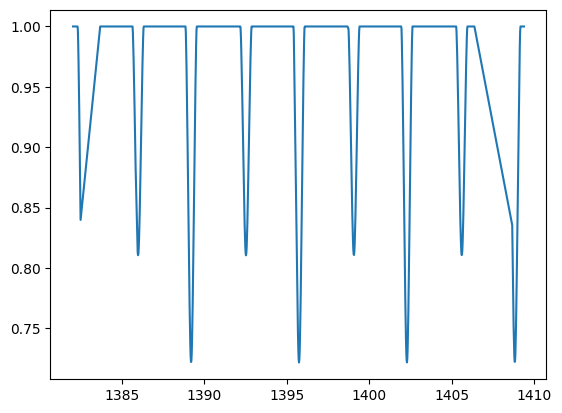

In [43]:
signal, params = field1.bkg_variability_generator.instantiate_function(field1.orig_tpf.time.value)

# add to signals1D array
signals1D[0,:] = signal

# plt.plot(field1.orig_tpf.time.value, signal)
plt.plot(field1.orig_tpf.time.value, signals1D[0,:])
# plt.show()

In [62]:
imp.reload(field)

<module 'field' from '/Users/raeholcomb/Documents/GitHub/tess_sim/tess_sim/field.py'>

In [74]:
# test Field class
def signal_test(time):
    """Placeholder for a signal added to a star"""
    return 1 + 0.1 * np.sin(time * np.random.uniform(.5, 1.5))

# test = signal_test(tpf_cutout.time.value)
# plt.plot(tpf_cutout.time.value, test)
# plt.show()

# type(source_cat)

field1 = field.Field(tpf_cutout, source_cat , bkg_polyorder=2,
                     bkg_variability_generator=fs, 
                     pos_time=tpf_pl.time.value, pos_corr1=tpf_pl.pos_corr1, pos_corr2=tpf_pl.pos_corr2, noise_func=trc.exponential, noise_coeffs=np.array([ 0.00309107,  2.238249  , -0.0438357 ]))
field1.calc_bkg()
# field1.add_signal(signal_test)
# field1.calc_empirical_noise()
# field1.assemble()
# field1.to_tpf().animate(clim=[120,260])

## Multisector development

In [57]:
# make two fields
field1 = field.Field(tpf_cutout1, source_cat , bkg_polyorder=2,
                     bkg_variability_generator=fs, 
                     pos_time=tpf_pl1.time.value, 
                     pos_corr1=tpf_pl1.pos_corr1, 
                     pos_corr2=tpf_pl1.pos_corr2, 
                     noise_func=trc.exponential, 
                     noise_coeffs=np.array([ 0.00309107,  2.238249  , -0.0438357 ]),
                     add_offset=True)

field2 = field.Field(tpf_cutout2, source_cat , bkg_polyorder=2,
                     bkg_variability_generator=fs, 
                     pos_time=tpf_pl2.time.value, 
                     pos_corr1=tpf_pl2.pos_corr1, 
                     pos_corr2=tpf_pl2.pos_corr2, 
                     noise_func=trc.exponential, 
                     noise_coeffs=np.array([ 0.00309107,  2.238249  , -0.0438357 ]),
                     add_offset=True)

# alias for ease haha
f1 = field1; f2=field2;
field_arr = [f1, f2]

In [64]:
print(len(np.concatenate([f1.time, f2.time])))

1077 1027
2104


In [32]:
# make two mini catalogs with some overlap to test around with merging
sc1 = source_cat[:5].copy()
sc2 = source_cat[3:7].copy()

print(len(sc1)+len(sc2))
print(len(set(sc1['ID']).union(set(sc2['ID']))))



9
7


In [38]:
from astropy import table
table.unique(table.vstack([sc1,sc2]), keys='ID')

ID,ra,dec,pmRA,pmDEC,Tmag,objType,typeSrc,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,POSflag,e_pmRA,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,dstArcSec
str9,float64,float64,float64,float64,float64,str4,str7,str8,str1,str12,str10,str16,str1,str19,str19,str8,str1,str7,float64,float64,str5,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,int64,float64,str1,str1,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,str5,float64,float64,float64,float64,int64,str1,str8,str8,str13,float64,float64,float64,float64,float64,float64,int64,int64,float64
396696262,65.3014634903041,-55.1131088158423,6.87588,9.57354,14.4043,STAR,tmgaia2,20190415,--,--,175-004294,04211234-5506471,--,J042112.36-550647.1,4778975273780694272,27219516,--,tmgaia2,0.0466075,0.0475618,gaia2,0.670416,0.0212567,gaia2,264.483187508645,-43.1826149264315,32.1942605550488,-73.5958607197366,15.592,0.063,15.082,0.16,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,13.851,0.027,13.542,0.038,13.434,0.047,AAA-222-111-000-0-0,nan,13.435,0.024,13.476,0.025,13.197,0.404,9.735,nan,14.8251,0.00037,0.006,rered,gaia2,5861.0,122.0,4.23446,nan,nan,nan,1.30153,nan,1.06,nan,0.480774,nan,DWARF,1.80090868,nan,1428.21,43.635,0.00546649,2.628115e-07,--,nan,--,--,nan,2.89262e-07,2.36361e-07,schlegel,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,42.33,44.94,bj2018,nan,nan,dered,15.1465,0.000955,14.3455,0.001316,1,--,ucac4,apassdr9,--,0.815153257376191,0.737587958722066,65.3015152501736,-55.1130675964461,0.0219378951664318,0.0236750718979537,1,0,111.29944582850786
396696265,65.2844009032428,-55.1189121967341,-7.78937,12.9002,15.8581,STAR,tmgaia2,20190415,--,--,--,04210825-5507080,--,J042108.24-550708.0,4778975170701479296,--,--,tmgaia2,0.161416,0.146413,gaia2,4.21042,0.0665915,gaia2,264.494271707841,-43.1905892324967,32.1542327293685,-73.5948070362816,19.153,0.179,18.353,0.048,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,14.268,0.036,13.635,0.033,13.39,0.054,AAA-222-111-000-0-0,nan,13.275,0.023,13.117,0.024,13.121,0.378,9.832,nan,17.1173,0.001264,0.00819586,cdwrf,cdwrf,3363.0,157.0,4.85478,0.00497913,nan,nan,0.369872,0.0136555,0.357122,0.0222583,7.05768,0.341768,DWARF,0.0157654043,0.004133769,235.967,3.737,0.00416927,nan,51,0.8076071,--,--,0.000271340134,nan,nan,schlegel,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,bj2018,nan,nan,cdwrf,18.5559,0.01488,15.9237,0.004028,1,--,gaia2,bpbj,cooldwarfs_v8,2.82308100055448,2.27052577054096,65.2843422583325,-55.11885665422,0.0714388624971791,0.0714430296694972,1,0,97.5956126844125
396696266,65.2773671059442,-55.1227399886111,20.9339,-32.2055,14.3035,STAR,tmgaia2,20190415,--,--,175-004289,04210656-5507217,--,J042106.58-550722.1,4778975136341741440,27219475,--,tmgaia2,0.0590618,0.0482718,gaia2,2.22411,0.0233785,gaia2,264.500747277484,-43.193

In [28]:
sc1

ID,ra,dec,pmRA,pmDEC,Tmag,objType,typeSrc,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,POSflag,e_pmRA,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,dstArcSec
str9,float64,float64,float64,float64,float64,str4,str7,str8,str1,str12,str10,str16,str1,str19,str19,str8,str1,str7,float64,float64,str5,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,int64,float64,str1,str1,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,str5,float64,float64,float64,float64,int64,str1,str8,str8,str13,float64,float64,float64,float64,float64,float64,int64,int64,float64
396696273,65.3022779524928,-55.1440218215514,-4.68889,-172.823,13.8321,STAR,tmgaia2,20190415,--,--,175-004296,04211254-5508385,--,J042112.53-550840.3,4778975067622266240,27219519,--,tmgaia2,0.121906,0.106763,gaia2,13.6125,0.0488118,gaia2,264.524040110307,-43.1743480616533,32.1310767676151,-73.6211175412397,18.094,-0.188,17.5,0.2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,12.254,0.026,11.7,0.023,11.419,0.021,AAA-222-111-000-0-0,nan,11.281,0.023,11.09,0.02,10.967,0.058,9.448,nan,15.128,0.000702,0.00735174,cdwrf,cdwrf,3298.0,157.0,4.92576,0.00562113,nan,nan,0.299954,0.00903524,0.276565,0.02021,10.2479,0.175918,DWARF,0.009589735,0.00241744542,73.3077,0.2643,0.0,0.0,61,0.04365064,--,--,0.0021988363,0.0,0.0,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.2634,0.2652,bj2018,nan,nan,cdwrf,16.6697,0.005701,13.9089,0.001417,1,--,cdwrf,apassdr9,cooldwarfs_v8,2.13222575228986,1.65563517607877,65.3022426283863,-55.1447659205903,0.0499553011456178,0.0517406142901303,1,0,0.0
396696276,65.2967867766935,-55.1550175340301,6.26182,11.5862,13.1813,STAR,tmgaia2,20190415,--,--,175-004292,04211122-5509180,--,J042111.23-550917.9,4778974689665144576,27219508,--,tmgaia2,0.0298366,0.0319423,gaia2,1.17206,0.0140643,gaia2,264.539715866452,-43.1745994569882,32.0990922362286,-73.62814882571,14.197,0.03,13.838,0.149,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,12.628,0.027,12.344,0.023,12.322,0.027,AAA-222-111-000-0-0,nan,12.311,0.023,12.334,0.022,12.094,0.151,9.748,nan,13.5561,0.000291,0.006,rered,gaia2,6160.0,122.0,4.33006,nan,nan,nan,1.22489,nan,1.17,nan,0.636638,nan,DWARF,1.946315,nan,832.614,9.8235,0.0054832,2.16022e-06,--,nan,--,--,nan,2.19932e-06,2.12112e-06,schlegel,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,9.71,9.937,bj2018,nan,nan,dered,13.8354,0.001602,13.1247,0.001145,1,--,ucac4,apassdr9,--,0.521919937973942,0.495352900420056,65.2968339635893,-55.1549676490118,0.0135094013728177,0.0156490029279675,1,0,41.16484036924621
396696267,65.2754685020188,-55.124256141076,18.7408,15.5449,14.7411,STAR,tmgaia2,20190415,--,--,175-004288,04210610-5507272,--,J042106.13-550727.0,4778975136341741568,--,--,tmgaia2,0.0650996,0.0620417,gaia2,2.90222,0.0292204,gaia2,264.503136191664,-43.1941782671891,32.1284714

## Lightcurve Extration

In [ ]:
# two different approaches to lc extraction
# 1. Dax's way, uses a threshold mask
# 2. Christina's way, uses the prf to do a cumulative sum to get 90% of the flux

In [51]:
ffi1 = field1.to_tpf()

In [50]:
imp.reload(trc)
imp.reload(field)
imp.reload(gen)

<module 'generator_classes' from '/Users/raeholcomb/Documents/GitHub/sset/sset/generator_classes.py'>

### Dax's Method

In [185]:
ffi1 = field1.to_tpf()
Sector = ffi1.get_header()['SECTOR']
ID = 1111
cutoutsize=cutout_size
name='Test1'

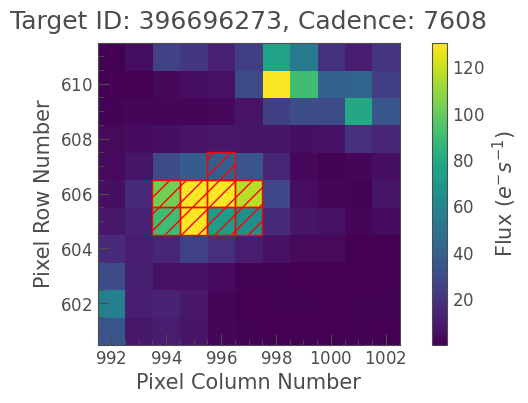

In [186]:
# plot the pipeline mask
tpf_pl.plot(aperture_mask=tpf_pl.create_threshold_mask(threshold))
plt.show()

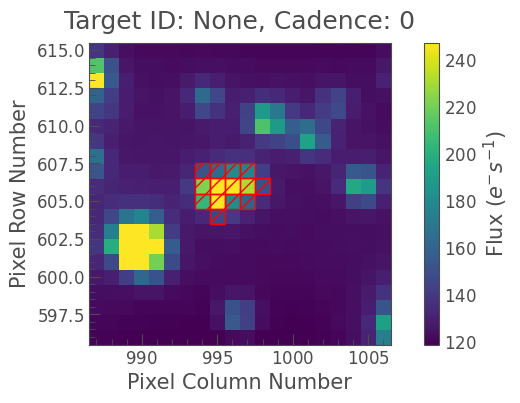

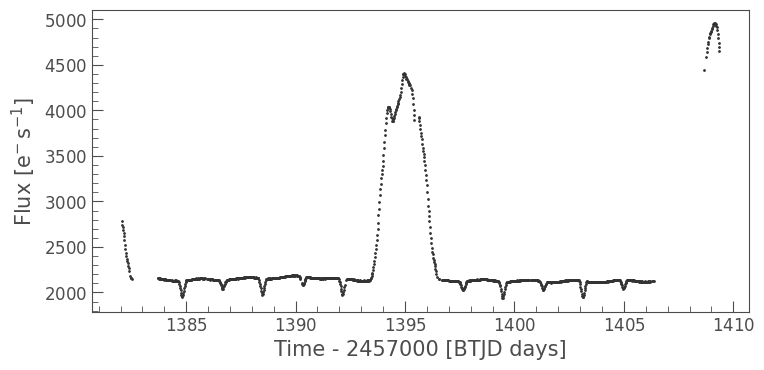

In [187]:
threshold=3

# plot the threshold mask for the sim tpf
ffi1.plot(aperture_mask=ffi1.create_threshold_mask(threshold))
plt.show()

star1 = ffi1.to_lightcurve(aperture_mask=ffi1.create_threshold_mask(threshold))
star1.scatter()
plt.show()

selected threshold:  3
len check   T 1077  SAP 1077  E  1077
shape check   T (1077,)  SAP (1077,)  E  (1077,)
electron / s electron / s
RAW len check: 1077 1077 1077
selected threshold:  3
len check   T 1077  SAP 1077  E  1077
shape check   T (1077,)  SAP (1077,)  E  (1077,)
electron / s electron / s
RAW len check: 1077 1077 1077


/Users/raeholcomb/Documents/GitHub/sset/sset/trc_funcs.py:723: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.html
  return np.abs(n95 - n5)


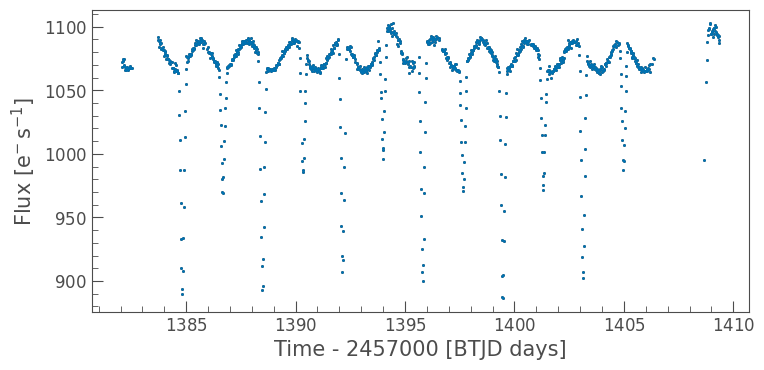

In [188]:
# function call, simplified!
threshold=3
cadence = '30 minute'
sap_lc1 = trc.nemesis_SAP(ffi1,threshold,cadence,
        verbose=True,
        use_SPOC_aperture=True,
        use_centroid=False,use_circ=False,
        use_sources_in_aperture=False)
sap_lc2 = trc.nemesis_SAP(ffi1,threshold,cadence,
        verbose=True,
        use_SPOC_aperture=False,
        use_centroid=True,use_circ=False,
        use_sources_in_aperture=False)

ax = sap_lc1.scatter()
sap_lc2.scatter(ax=ax)
# sap_lc2.scatter()
plt.show()

selected threshold:  3
len check   T 1077  SAP 1077  E  1077
shape check   T (1077,)  SAP (1077,)  E  (1077,)
electron / s electron / s
RAW len check: 1077 1077 1077
selected aperture mask is  1.98 pixels from reference pixel! Using circular aperture (r = 1.5 pixels) around reference pixel instead
selected threshold:  3
len check   T 1077  SAP 1077  E  1077
shape check   T (1077,)  SAP (1077,)  E  (1077,)
electron / s electron / s
RAW len check: 1077 1077 1077


/Users/raeholcomb/Documents/GitHub/sset/sset/trc_funcs.py:723: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.html
  return np.abs(n95 - n5)


<AxesSubplot: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

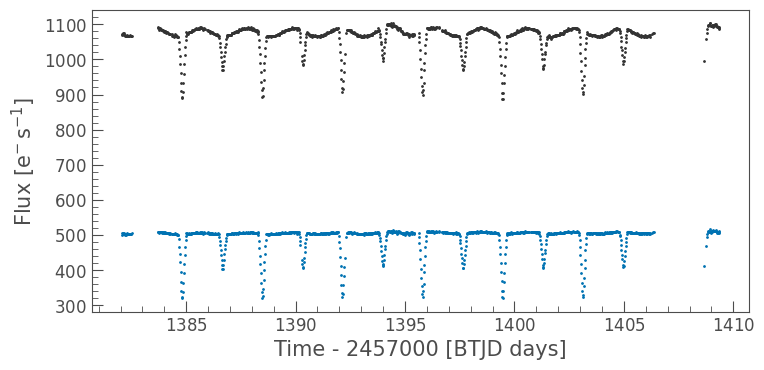

In [195]:
# try it on the field1 object
sap_lc1 = field1.nemesis_lc_extraction(3, "30 minute",verbose=True,
            use_SPOC_aperture=True,
            use_centroid=False,
            use_circ=False,
            use_sources_in_aperture=False)
sap_lc2 = field1.nemesis_lc_extraction(3, "30 minute",verbose=True,
            use_SPOC_aperture=False,
            use_centroid=False,
            use_circ=True,
            use_sources_in_aperture=False)
ax = sap_lc1.scatter()
sap_lc2.scatter(ax=ax)

In [217]:
sap_lc1.flux_err

test_lc = lk.LightCurve(time=sap_lc1.time,flux=sap_lc1.flux,
                           flux_err=sap_lc1.flux_err)#, meta={'TICID':10000})
test_lc.meta['TICID'] = 10

test_lc.TICID


10

### Christina Method

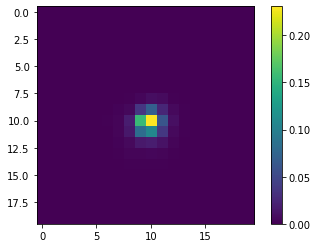

In [110]:
# arr = field1.prf.locate(5, 5, field1.shape)
arr = field1.prf.locate(field1.source_catalog[0]['pix1'], field1.source_catalog[0]['pix2'], field1.shape)
plt.imshow(arr)
plt.colorbar()



In [99]:
def generate_mask(array_2d, threshold):
    """Generates an aperture mask based on the expected source PRF. Returns the mask and the expected flux fraction of the aperture. The threshold is in terms of the flux fraction recovered from the target."""
    # Flatten the 2D array and create a mask with the same shape
    flat_array = array_2d.flatten()
    mask = np.zeros_like(flat_array, dtype=bool)
    
    # Get indices that would sort the array in descending order
    sorted_indices = np.argsort(flat_array)[::-1]
    
    # Iterate through sorted indices and update mask
    cumulative_sum = 0.0
    for idx in sorted_indices:
        cumulative_sum += flat_array[idx]
        mask[idx] = True
        if cumulative_sum > threshold:
            break
    
    # Reshape the mask to match the original 2D array shape
    mask = mask.reshape(array_2d.shape)
    
    return mask, cumulative_sum

# Example usage
threshold_value = 0.6
input_array = np.array([[0.2, 0.3, 0.4],
                        [0.1, 0.5, 0.6],
                        [0.8, 0.7, 0.9]])

result_mask, flfr = generate_mask(input_array, threshold_value)
print(result_mask)

[[False False False]
 [False False False]
 [False False  True]]


0.900632117751592


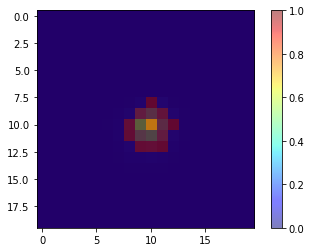

In [114]:
result_mask, flfr = generate_mask(arr, 0.9)
print(flfr)
# print(result_mask)

plt.imshow(arr)
plt.imshow(result_mask, cmap='jet', alpha=0.5) # interpolation='none'
plt.colorbar()

In [116]:
# calculate the crowdsap (crsp)
# crowdsap - the ratio of target flux relative to the total flux within the photometric aperture including contaminat-ing sources.

# do expected crowdsap based on the prfs in the source catalog?
np.shape(field1.signals2D[1])

def calc_crowdsap(tpf, s_ind, aper):
    """Given a field object, the index of a source in its source catalog, and an aperture, calculates the crowdsap within that aperture."""
    crowdflux = 0.

    for ind in range(len(tpf.source_catalog)):        
        row = tpf.source_catalog[ind]
        # get the prf
        try:
            source_prf = tpf.prf.locate(row['pix1']+np.median(tpf.pos_corr[0]), row['pix2']+np.median(tpf.pos_corr[1]), tpf.shape)
        except:
            print("Couldn't find PRF for target index " + str(ind))

        # multiply the prf by the Tflux, then add the contribution within the aperture
        # if this is our target star save as the source_flux, else it's crowding
        if ind == s_ind :
            sourceflux = np.sum((source_prf * row['Tflux'])[aper])
        else :
            crowdflux += np.sum((source_prf * row['Tflux'])[aper])

    # now calculate the flux from the source in the     
    return sourceflux / (crowdflux+sourceflux)

calc_crowdsap(field1, 0, result_mask)

        


0.5394621925868699